<a href="https://colab.research.google.com/github/nadiahsahidah/tweet-emotion-sentimen-analysis/blob/main/Source_Code_DAC_Fantastic_Four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install Package
!pip install -q transformers google-api-python-client wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import string
import re
import os
import matplotlib.pyplot as plt
import plotly.express as px
import googleapiclient.discovery
from wordcloud import WordCloud
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
filename = 'Dataset Babak Penyisihan.csv'

In [ ]:
data = pd.read_csv(filename)

In [ ]:
data.head()

,label,tweet
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,..."
2,joy,Jumat lalu nonton inih! Selain tertarik settin...
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...
4,love,Happy annyversarry yg pertama kalinya .. Trsra...


#**Preprocessing Data**

In [ ]:
import string

def count_punct(text):
    if isinstance(text, str):  # Check if the value is a string
        count = sum([1 for char in text if char in string.punctuation])
        return round(count / (len(text) - text.count(" ")), 3) * 100
    else:
        return 0  # Handle non-string values (e.g., float)

def calculate_tweet_len(text):
    if isinstance(text, str):  # Check if the value is a string
        return len(text) - text.count(" ")
    else:
        return 0  # Handle non-string values (e.g., float)

data['tweet_len'] = data['tweet'].apply(calculate_tweet_len)
data['punct'] = data['tweet'].apply(count_punct)
data.head()

,label,tweet,tweet_len,punct
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2


Cleaning, case folding, remove punct

In [ ]:
def clean_text(text):
  text = re.sub(r'[^a-zA-Z0-9]', ' ', str(text)).lower()
  text = re.sub(r'\b\w(1,2)\b', ' ', text) #menghilangkan 2 kata
  text = re.sub(r'\s\s+', ' ', text)
  text = re.sub(r'\([0-9]+\)|[^a-zA-Z\s]|\(|\)|\d+', '', text)
  text = re.sub(r'\b(?:m{0,4}(?:cm|cd|d?c{0,3})(?:xc|xl|l?x{0,3})(?:ix|iv|v?i{0,3}))\b', ' ', text)
  text = " ".join(text.split())
  return text

data['cleaned_text'] = data['tweet'].apply(lambda x: clean_text(x))
data.head(20)

,label,tweet,tweet_len,punct,cleaned_text
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4,lebih menyeramkan kalo punya grup wa keluarga ...
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3,hepibesdey canteeeekk username panjang umur ja...
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8,jumat lalu nonton inih selain tertarik setting...
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5,nyante dulu sruput kopi biar tambah bijak
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2,happy annyversarry yg pertama kalinya trsrah o...
5,sadness,beli kaos banyak dengan ukuran yg udah downgra...,127,2.4,beli kaos banyak dengan ukuran yg udah downgra...
6,love,Pada saat kamu menangis merengek meminta bonek...,148,4.7,pada saat kamu menangis merengek meminta bonek...
7,anger,[USERNAME] tolong aplikasinya diberesin. Saya ...,121,6.6,username tolong aplikasinya diberesin saya tad...
8,sadness,"Percaya kata lelaki itu, terutama ketika aku i...",192,4.2,percaya kata lelaki itu terutama ketika aku in...
9,sadness,ada saatnya sakit hati itu kita nikmatin denga...,154,2.6,ada saatnya sakit hati itu kita nikmatin denga...


Tokenization

In [ ]:
def tokenize_text(text):
    tokenized_text = text.split()
    return tokenized_text
data['tokens'] = data['cleaned_text'].apply(lambda x: tokenize_text(x))
data.head()

,label,tweet,tweet_len,punct,cleaned_text,tokens
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4,lebih menyeramkan kalo punya grup wa keluarga ...,"[lebih, menyeramkan, kalo, punya, grup, wa, ke..."
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3,hepibesdey canteeeekk username panjang umur ja...,"[hepibesdey, canteeeekk, username, panjang, um..."
2,joy,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8,jumat lalu nonton inih selain tertarik setting...,"[jumat, lalu, nonton, inih, selain, tertarik, ..."
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5,nyante dulu sruput kopi biar tambah bijak,"[nyante, dulu, sruput, kopi, biar, tambah, bijak]"
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2,happy annyversarry yg pertama kalinya trsrah o...,"[happy, annyversarry, yg, pertama, kalinya, tr..."


----

#Analisis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153 entries, 0 to 5152
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   label         4153 non-null   object 
 1   tweet         5151 non-null   object 
 2   tweet_len     5153 non-null   int64  
 3   punct         5153 non-null   float64
 4   cleaned_text  5153 non-null   object 
 5   tokens        5153 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 241.7+ KB


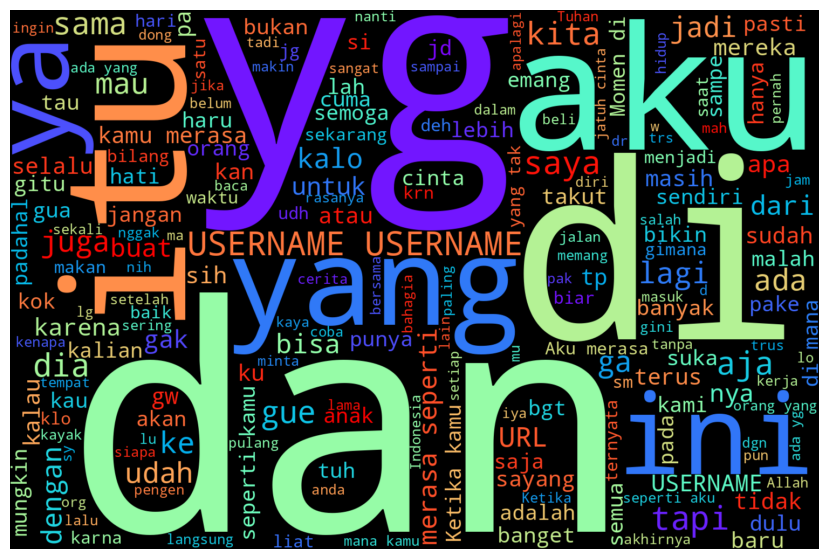

In [ ]:
# Combine all tweet into a single string
all_tweet = " ".join(str(tweet) for tweet in data['tweet'])

# Create a WordCloud object with black background and rainbow colors
wordcloud = WordCloud(
    background_color='black',  # Set background color to black
    colormap='rainbow',        # Set colormap to rainbow
    width=1500,                 # Set the width of the word cloud image
    height=1000,                # Set the height of the word cloud image
    max_words=200,             # Maximum number of words to include in the word cloud
    random_state=42            # Set a random state for reproducibility
).generate(all_tweet)

# Display the word cloud using matplotlib
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
# Define the model name
model_name = "StevenLimcorn/indonesian-roberta-base-emotion-classifier"

pipe = pipeline(
"text-classification",
model=model_name)

In [ ]:
pipe("Happy Mensive My Love makasih udh nemenin selama tiga bulan ini. ga kerasa udh panjang aja perjalanannya, selama ini aku ngerasa belum ngasih apa apa buat kamu maaf aku ga bisa romantis, kerjaan aku cuma jailin kamu. tapi kamu harus percaya tiap detik aku selalu sayang kamu")

[{'label': 'love', 'score': 0.9871297478675842}]

In [ ]:
# Get details about the model
model = AutoModelForSequenceClassification.from_pretrained(model_name)
print("\nModel details:")
print(model)


Model details:
RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [ ]:
data_test = data[4153:5153]
label = []
score = []
for i in data['cleaned_text']:
  sentimen_list = pipe(i)
  label.append(sentimen_list[0]['label'])
  score.append(sentimen_list[0]['score'])

In [ ]:
data_test = data.copy()

In [ ]:
data_test['label'] = label
data_test['score'] = score

In [ ]:
data_test

,label,tweet,tweet_len,punct,cleaned_text,tokens,score
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4,lebih menyeramkan kalo punya grup wa keluarga ...,"[lebih, menyeramkan, kalo, punya, grup, wa, ke...",0.983777
1,happy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3,hepibesdey canteeeekk username panjang umur ja...,"[hepibesdey, canteeeekk, username, panjang, um...",0.989825
2,happy,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8,jumat lalu nonton inih selain tertarik setting...,"[jumat, lalu, nonton, inih, selain, tertarik, ...",0.917616
3,sadness,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5,nyante dulu sruput kopi biar tambah bijak,"[nyante, dulu, sruput, kopi, biar, tambah, bijak]",0.409745
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2,happy annyversarry yg pertama kalinya trsrah o...,"[happy, annyversarry, yg, pertama, kalinya, tr...",0.839304
...,...,...,...,...,...,...,...
5148,anger,Aku termasuk orang yang tidak habis pikir deng...,210,1.4,aku termasuk orang yang tidak habis pikir deng...,"[aku, termasuk, orang, yang, tidak, habis, pik...",0.642799
5149,happy,"Melawan sibuk Selasamu, jangan patah semangat ...",44,4.5,melawan sibuk selasamu jangan patah semangat yah,"[melawan, sibuk, selasamu, jangan, patah, sema...",0.682055
5150,happy,Momen di mana kamu merasa begitu mendalam terh...,134,2.2,momen mana kamu merasa begitu mendalam terhubu...,"[momen, mana, kamu, merasa, begitu, mendalam, ...",0.583089
5151,sadness,Tapi tentunya secara ini Bekasi ada hal-hal yg...,223,5.4,tapi tentunya secara ini bekasi ada hal hal yg...,"[tapi, tentunya, secara, ini, bekasi, ada, hal...",0.633015


In [ ]:
import plotly.express as px

# Generate label counts
label_counts = data_test['label'].value_counts()

# Create a pie chart
fig = px.pie(
    label_counts,
    values=label_counts.values,
    names=label_counts.index,
    title="Sentiment Distribution",
)

# Update layout for better readability
fig.update_layout(title_text="Sentiment Distribution", showlegend=True)

# Show the pie chart
fig.show()


In [ ]:
data_test

,label,tweet,tweet_len,punct,cleaned_text,tokens,score
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...,129,5.4,lebih menyeramkan kalo punya grup wa keluarga ...,"[lebih, menyeramkan, kalo, punya, grup, wa, ke...",0.983777
1,happy,"Hepibesdey canteeeekk [USERNAME] panjang umur,...",131,5.3,hepibesdey canteeeekk username panjang umur ja...,"[hepibesdey, canteeeekk, username, panjang, um...",0.989825
2,happy,Jumat lalu nonton inih! Selain tertarik settin...,185,3.8,jumat lalu nonton inih selain tertarik setting...,"[jumat, lalu, nonton, inih, selain, tertarik, ...",0.917616
3,sadness,Nyante dulu.. Sruput kopi biar tambah bijak...,40,12.5,nyante dulu sruput kopi biar tambah bijak,"[nyante, dulu, sruput, kopi, biar, tambah, bijak]",0.409745
4,love,Happy annyversarry yg pertama kalinya .. Trsra...,210,6.2,happy annyversarry yg pertama kalinya trsrah o...,"[happy, annyversarry, yg, pertama, kalinya, tr...",0.839304
...,...,...,...,...,...,...,...
5148,anger,Aku termasuk orang yang tidak habis pikir deng...,210,1.4,aku termasuk orang yang tidak habis pikir deng...,"[aku, termasuk, orang, yang, tidak, habis, pik...",0.642799
5149,happy,"Melawan sibuk Selasamu, jangan patah semangat ...",44,4.5,melawan sibuk selasamu jangan patah semangat yah,"[melawan, sibuk, selasamu, jangan, patah, sema...",0.682055
5150,happy,Momen di mana kamu merasa begitu mendalam terh...,134,2.2,momen mana kamu merasa begitu mendalam terhubu...,"[momen, mana, kamu, merasa, begitu, mendalam, ...",0.583089
5151,sadness,Tapi tentunya secara ini Bekasi ada hal-hal yg...,223,5.4,tapi tentunya secara ini bekasi ada hal hal yg...,"[tapi, tentunya, secara, ini, bekasi, ada, hal...",0.633015


---

In [ ]:
#Shape of the dataset, and breakdown of the classes
print(f"Input data has {len(data_test)} rows and {len(data_test.columns)} columns")
print(f"label anger = {len(data_test[data_test['label']=='anger'])} rows")
print(f"label sadness = {len(data_test[data_test['label']=='sadness'])} rows")
print(f"label fear = {len(data_test[data_test['label']=='fear'])} rows")
print(f"label happy = {len(data_test[data_test['label']=='happy'])} rows")
print(f"label love = {len(data_test[data_test['label']=='love'])} rows")

Input data has 5153 rows and 7 columns
label anger = 1132 rows
label sadness = 1438 rows
label fear = 756 rows
label happy = 1053 rows
label love = 774 rows


Index(['label', 'tweet', 'tweet_len', 'punct', 'cleaned_text', 'tokens',
       'score'],
      dtype='object')


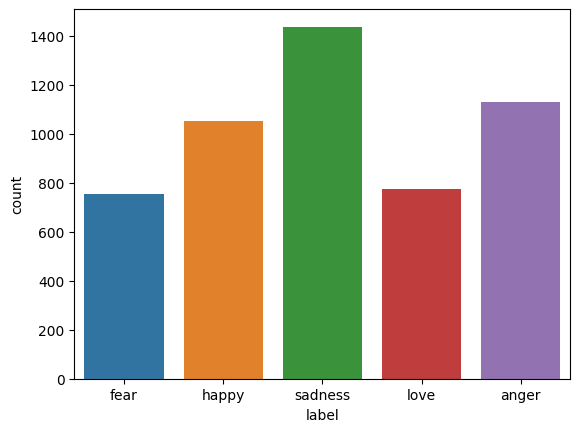

In [ ]:
# Missing values in the dataset
import seaborn as sns
import matplotlib.pyplot as plt
print(data_test.columns)
# Assuming 'label' is a valid column name in data_test
sns.countplot(x='label', data=data_test)
plt.show()

-----